# Import Libraries

In [1]:
import pandas as pd
import arff
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Preprocessing and Creation of DF

In [2]:
data_freq = arff.load('/workspaces/coding_challenge/df/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('/workspaces/coding_challenge/df/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

# change dtypes of ID to int 
df_freq['IDpol'] = df_freq['IDpol'].astype(int)
# also I set the ID as index
df_freq.set_index("IDpol", inplace=True)

# same for df_sev
df_sev['IDpol'] = df_sev['IDpol'].astype(int)

# check on missing values in both datasets
print(f"Total amount of missing values in df_freq {df_freq.isnull().sum()}")
print("---------")
print(f"Total amount of missing values in df_sev {df_sev.isnull().sum()}")

#I want one row per ID and the sum of all claim amounts for that ID
df_sev = df_sev.groupby("IDpol").sum()
#Now I join the two datasets
df = df_freq.join(df_sev, how="left")

print("---------")
print(f"Total amount of missing values in df {df.isnull().sum()}")
# I assume for the rest of the data that no row in df_sev means claim amount = 0
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

# check if there are claim amounts for claim number 0, which would't make any sense to me...
print(f"Quick logical check: A total of {len(df[(df.ClaimNb == 0) & (df.ClaimAmount != 0.0)])} rows have ClaimNb = 0 but ClaimAmount != 0")

# And create the new dependent variable ClaimAmount/Exposure
df["ClaimAmountDivByExposure"] = df["ClaimAmount"]/df["Exposure"]

Total amount of missing values in df_freq ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64
---------
Total amount of missing values in df_sev IDpol          0
ClaimAmount    0
dtype: int64
---------
Total amount of missing values in df ClaimNb             0
Exposure            0
Area                0
VehPower            0
VehAge              0
DrivAge             0
BonusMalus          0
VehBrand            0
VehGas              0
Density             0
Region              0
ClaimAmount    653069
dtype: int64
Quick logical check: A total of 0 rows have ClaimNb = 0 but ClaimAmount != 0


# Summary statistics

In [4]:
# get summary statistics for the dataset (continuous variables only)
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmountDivByExposure
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,6.780130e+05
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,3.832608e+02
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,3.682070e+04
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07


In [5]:
# get summary statistics for the dataset (categorical variables only)
df.describe(include="object")

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,'C','B12',Regular,'R24'
freq,191880,166024,345877,160601


# Plots

### Continous variables

/tmp/ipykernel_2903/2176863589.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax, bins=40)


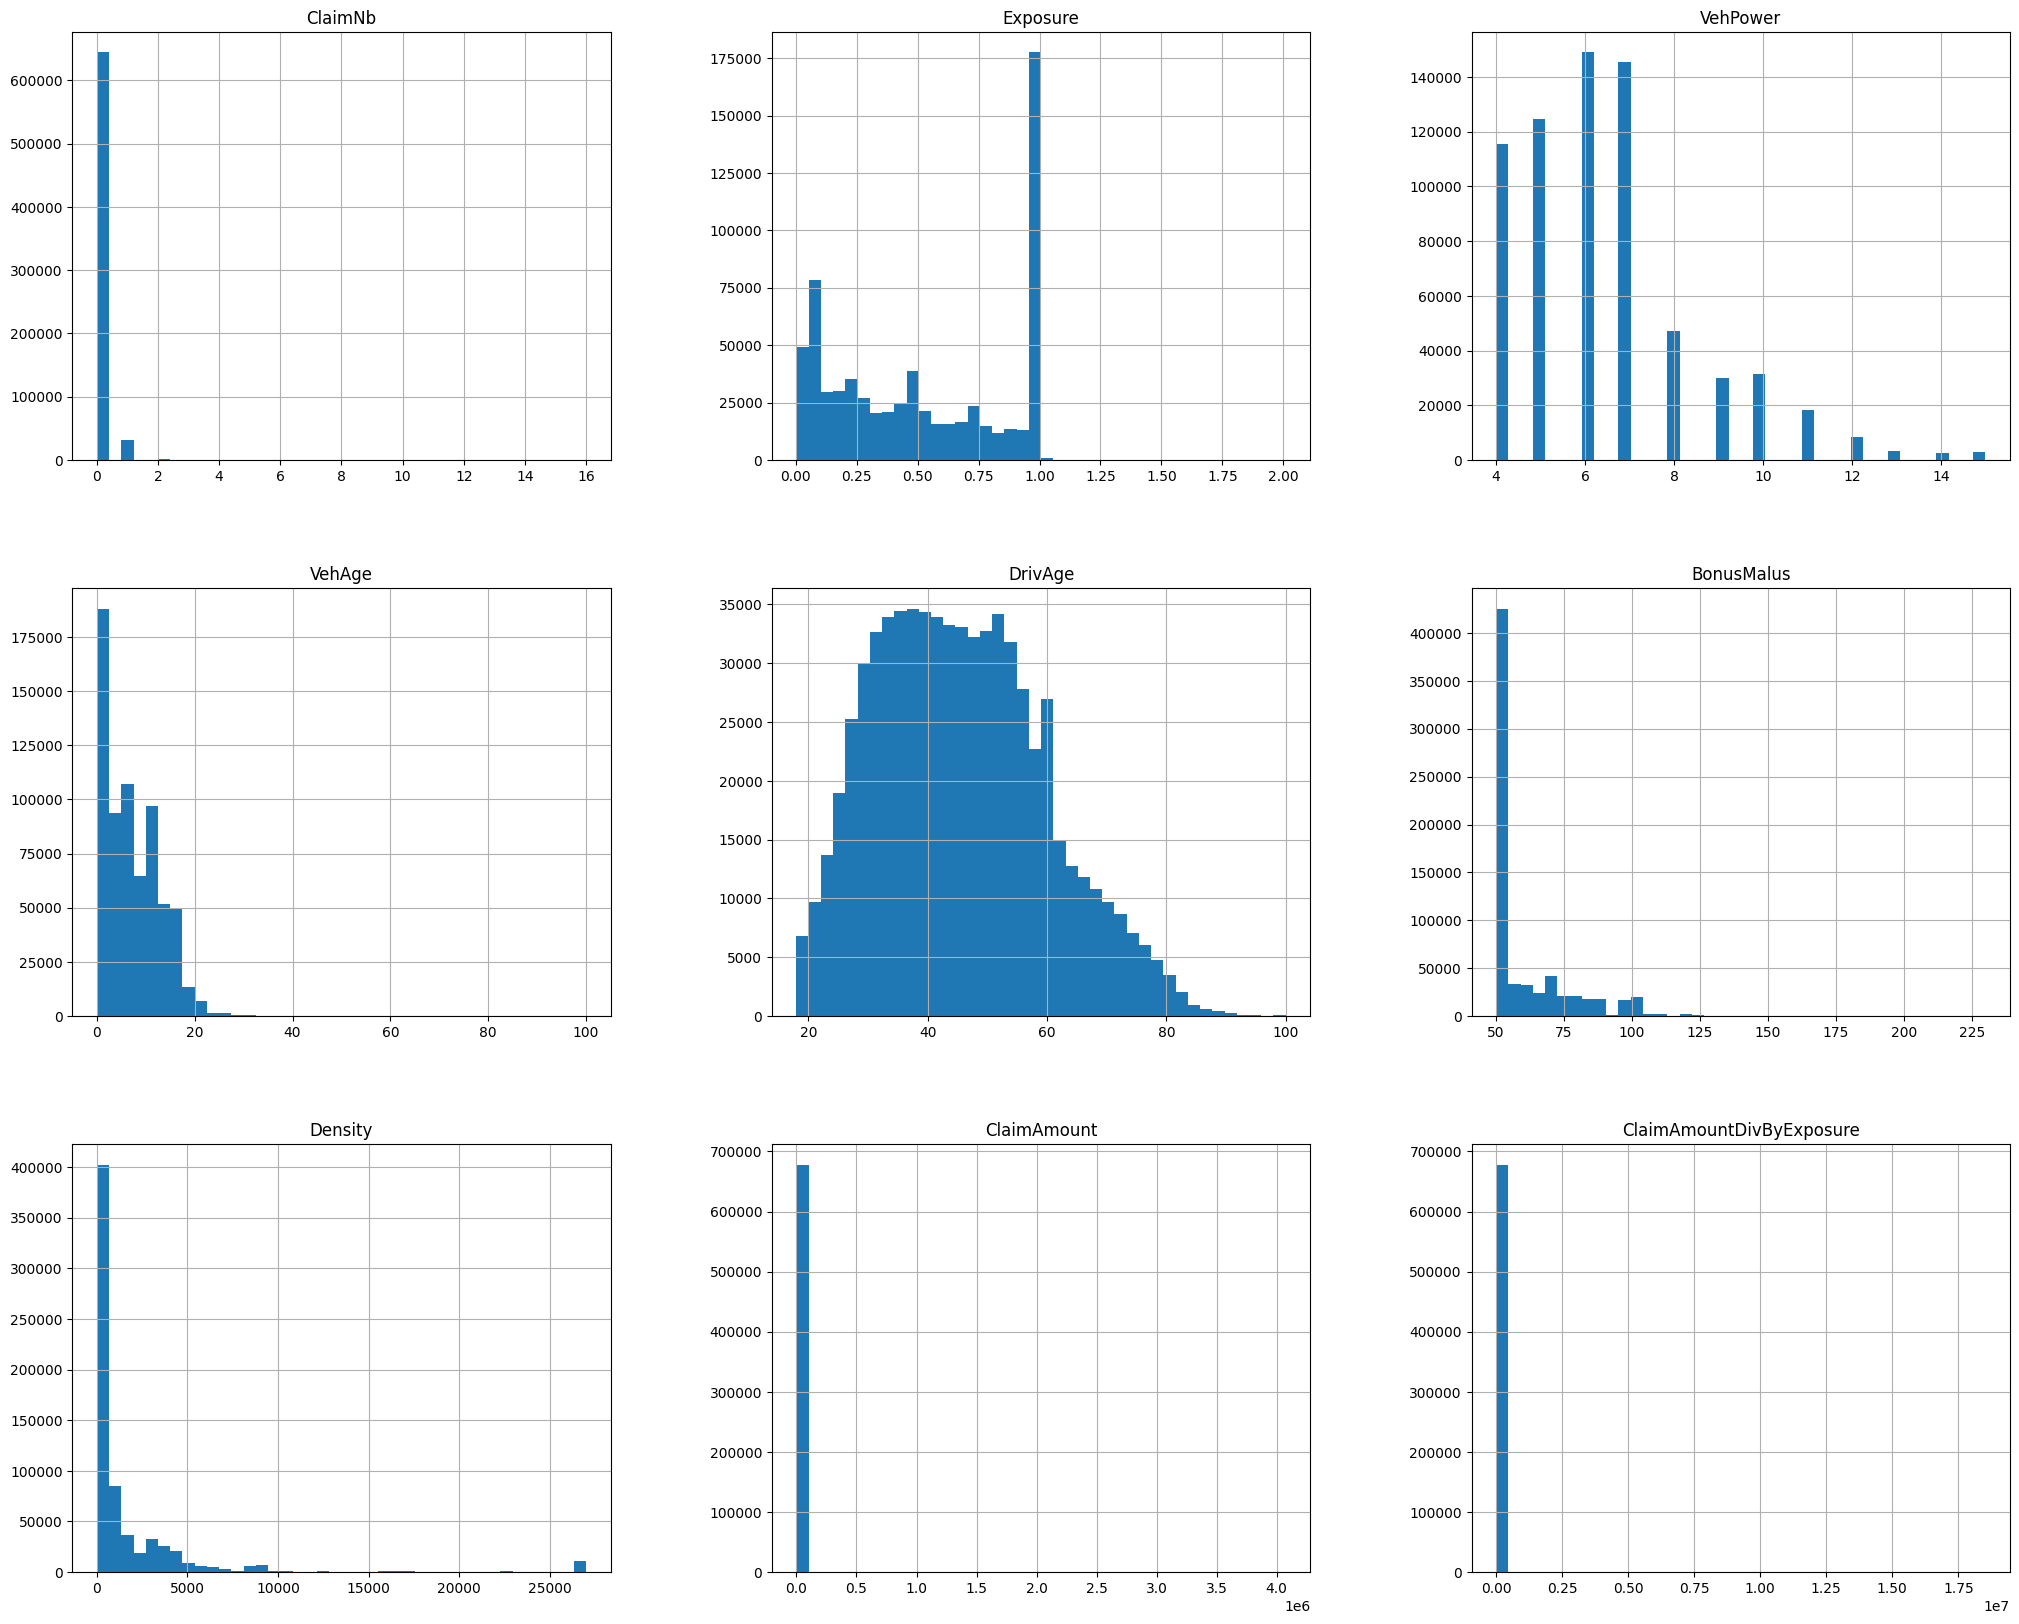

In [6]:
# plot the distributions of all continuous variables with a large plot size
fig = plt.figure(figsize = (25,20))
ax = fig.gca()
df.hist(ax = ax, bins=40)
plt.show()

In [7]:
# (potential) independent variable
# how much of BonusMalus is 50 (appears to be the minimum)?
print(df[df.BonusMalus == 50].shape[0] / df.shape[0]) # Almost 57%  

# how much of VehAge is 0 (appears to be the minimum)?
print(df[df.VehAge == 0].shape[0] / df.shape[0]) # Almost 8%  

# target variable 
#how much of our target variable ClaimAmountDivByExposure is zero? 
print(df[df.ClaimAmountDivByExposure == 0.0].shape[0] / df.shape[0]) # almost 96% !!
# --> this could be a problem... 

0.5665909060740724
0.08515913411689746
0.9632101449382239


(potential) Independent variables:
- In general **most of the distributions appear to be skewed to the right** -> Model should be capable of handling such skewed distributions

Dependent variable: 
- Also our newly generated **target variable ClaimAmountDivByExposure is highly skewed to the right**. This means for over 96% of our contracts we have absolutely no claim in the exposed period so far... 

With a real case at a company I'd get in contact with some other data scientists / engineers but also domain experts regarding the topic of our highly skewed data to understand the underlying data generating process much better and brainstorm on what to do.

### Categorial variables

<Axes: xlabel='Area'>

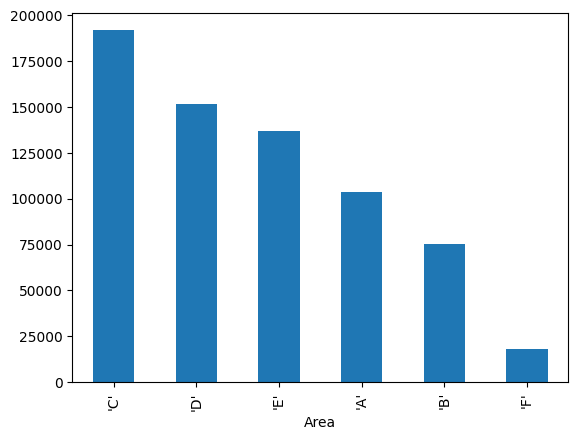

In [8]:
# plot the distributions of all categorial variables
df['Area'].value_counts().plot(kind='bar')

- Right skew, but nothing too dramatic in my opinion

<Axes: xlabel='VehBrand'>

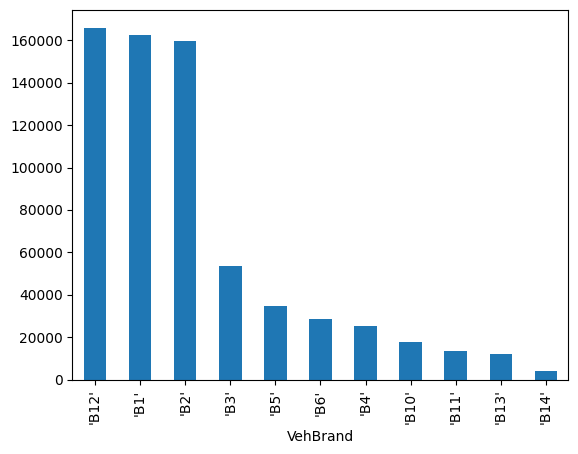

In [9]:
df['VehBrand'].value_counts().plot(kind='bar')

- Dominance of Vehicle Brands B12, B1 and B2 

<Axes: xlabel='VehGas'>

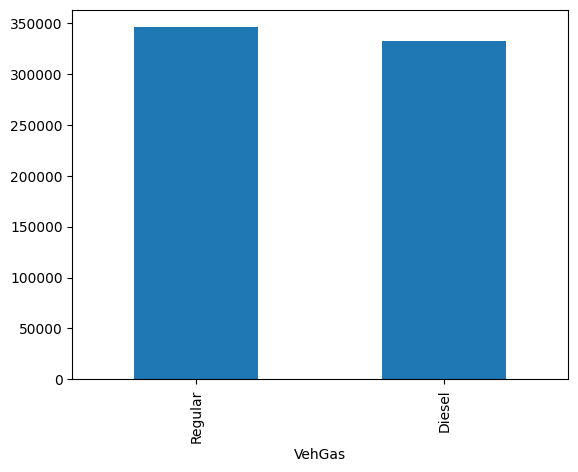

In [10]:
df['VehGas'].value_counts().plot(kind='bar')

- VehGas appears to be rather even

<Axes: xlabel='Region'>

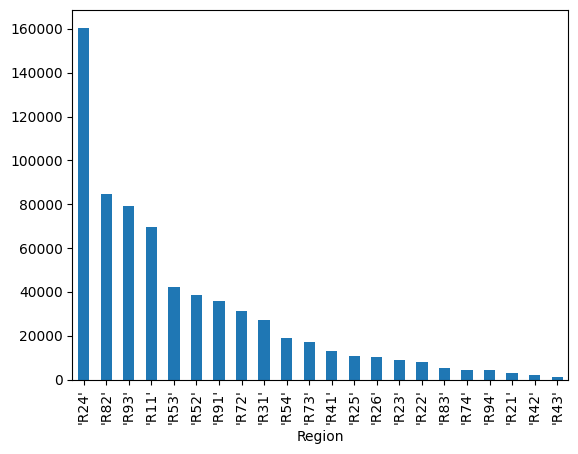

In [11]:
df['Region'].value_counts().plot(kind='bar')

- R24 appears to dominate the regions. Why is this the case? Could be the capital region or another areas with higher density of population --> Maybe check for some correlation with area or density

### Correlations of (independent) variables

### Continous variables

<Axes: >

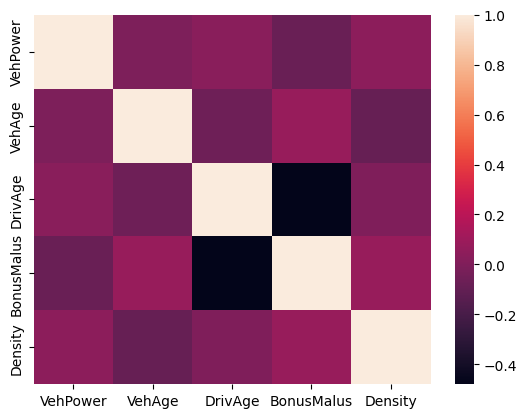

In [12]:
# Plot of correlations between all continuous variables

# get only variables with numeric values and exlude ClaimAmountDivByExposure
df_num = df.drop(columns=["ClaimAmountDivByExposure", "ClaimNb", "Exposure", "ClaimAmount"])._get_numeric_data()
corr = df_num.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [13]:
corr

,VehPower,VehAge,DrivAge,BonusMalus,Density
VehPower,1.000000,-0.006001,0.030108,-0.075895,0.042901
VehAge,-0.006001,1.000000,-0.059213,0.079923,-0.090428
DrivAge,0.030108,-0.059213,1.000000,-0.479966,-0.004700
BonusMalus,-0.075895,0.079923,-0.479966,1.000000,0.077717
Density,0.042901,-0.090428,-0.004700,0.077717,1.000000


- **Strongest negative correlation between drivers age and bonus malus** (-0.48) -> the higher the age the lower the BonusMalus score, which makes sense because the older I am the more likely I am to have a bonus (researched: score under 100)

Conclusion: There is some correlation between out independent continous variables, but most of the appears to be in the range of a very weak (0 - 0.2) or weak (0.2 - 0.4) assiciation, only one with a moderate correlation (0.4 - 0.6) and none with a strong (0.6 - 0.8) or a very strong (>0.8) one... 

### Categorial variables
As I'm not just interested in the connection/correlation between all my already categorial features but also categorial and continous ones <br> I'll put them into bins to mimick categorial traits. Afterwards Cramers V is calculated between them (kind of a correlation metric for categorial variables).

In [14]:
# get Cramers v for all categorical and binned continous variables
df_binned = df.copy()
df_binned["VehPower"] = pd.cut(df["VehPower"], 5)
df_binned["VehAge"] = pd.cut(df["VehAge"], 5)
df_binned["DrivAge"] = pd.cut(df["DrivAge"], 5)
df_binned["Density"] = pd.cut(df["Density"], 5)
df_binned["BonusMalus"] = pd.cut(df["BonusMalus"], 5)

def cramers_v(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table is being built 
  stat = stats.chi2_contingency(crosstab)[0] # Get Chi2 test statistic as base for cramers v
  obs = np.sum(crosstab) # Total observations count
  mini = min(crosstab.shape)-1 # Take the minimum between the columns and the rows to normalize 
  return np.sqrt(stat/(obs*mini))

categorical_vars = ["Area", "VehBrand", "VehGas", "Region", "VehPower", "VehAge", "DrivAge", "Density", "BonusMalus"]
cramers_v_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
total_calculations = len(categorical_vars)**2
count = 1
for var1 in categorical_vars:
    for var2 in categorical_vars:
        print(f"Finished cramers_v for {var1} and {var2}. {count} out of {total_calculations} done!") # for those that are interested in the progress of the calculations (e.g. if you are looking at a lot of variables)
        cramers_v_matrix.loc[var1, var2] = cramers_v(df[var1], df[var2])
        count += 1

cramers_v_matrix   

Finished cramers_v for Area and Area. 1 out of 81 done!
Finished cramers_v for Area and VehBrand. 2 out of 81 done!
Finished cramers_v for Area and VehGas. 3 out of 81 done!
Finished cramers_v for Area and Region. 4 out of 81 done!


Finished cramers_v for Area and VehPower. 5 out of 81 done!
Finished cramers_v for Area and VehAge. 6 out of 81 done!
Finished cramers_v for Area and DrivAge. 7 out of 81 done!
Finished cramers_v for Area and Density. 8 out of 81 done!
Finished cramers_v for Area and BonusMalus. 9 out of 81 done!
Finished cramers_v for VehBrand and Area. 10 out of 81 done!
Finished cramers_v for VehBrand and VehBrand. 11 out of 81 done!
Finished cramers_v for VehBrand and VehGas. 12 out of 81 done!
Finished cramers_v for VehBrand and Region. 13 out of 81 done!
Finished cramers_v for VehBrand and VehPower. 14 out of 81 done!
Finished cramers_v for VehBrand and VehAge. 15 out of 81 done!
Finished cramers_v for VehBrand and DrivAge. 16 out of 81 done!
Finished cramers_v for VehBrand and Density. 17 out of 81 done!
Finished cramers_v for VehBrand and BonusMalus. 18 out of 81 done!
Finished cramers_v for VehGas and Area. 19 out of 81 done!
Finished cramers_v for VehGas and VehBrand. 20 out of 81 done!
Finis

,Area,VehBrand,VehGas,Region,VehPower,VehAge,DrivAge,Density,BonusMalus
Area,1.0,0.073271,0.131439,0.319472,0.039764,0.057754,0.03525,0.998245,0.068059
VehBrand,0.073271,1.0,0.116514,0.130059,0.157553,0.172298,0.054065,0.167403,0.03567
VehGas,0.131439,0.116514,0.999997,0.094403,0.318737,0.147928,0.126834,0.206278,0.063486
Region,0.319472,0.130059,0.094403,1.0,0.043698,0.063758,0.035636,0.682931,0.036784
VehPower,0.039764,0.157553,0.318737,0.043698,1.0,0.074463,0.041159,0.12764,0.034772
VehAge,0.057754,0.172298,0.147928,0.063758,0.074463,1.0,0.020893,0.060783,0.018026
DrivAge,0.03525,0.054065,0.126834,0.035636,0.041159,0.020893,1.0,0.072974,0.092593
Density,0.998245,0.167403,0.206278,0.682931,0.12764,0.060783,0.072974,1.0,0.089338
BonusMalus,0.068059,0.03567,0.063486,0.036784,0.034772,0.018026,0.092593,0.089338,1.0


Very strong correlation (>0.25): 
- Region and area
- Vehicle power and vehicle gas 
- Density and area -> Quick research gave the result, that area code might have been created via density...  This would make sense as the association is almost perfect!
- Region and density

Strong correlation (>0.15): 
- vehicle power and brand 
- vehicle age and brand 
- Density and vehicle brand 
- Density and vehicle gas 

All other variables appear to be moderately or weakly connected...

Although there is some strong association between these real and artificial categorial variables 
I'll only exclude area, as it appears to be almost as high as the perfect diagonal associations of the variables with themselves and stick to density instead as both variables are more or less explaining the same variance.

In [15]:
df.drop('Area', axis=1, inplace=True)

**Overall conclusion of explorative data analysis**: There appear to be highly skewed variable ditributions but also correlated independent variables (some of them even in a strong manner) in our dataset. This has to be defenetively considered when choosing a modelling approach!!

# Feature creation

Drop ClaimNb, ClaimAmount and Exposure as they appear to be part of what we want to model here and ClaimAmountDivByExposure will be our dependent variable.

In [16]:
df.drop(columns=["ClaimNb", "ClaimAmount", "Exposure"], inplace=True) 

Separate continous from categorial data to test different data transformation strategies with the continous. For categorial data I stick to one hot encoding...

In [17]:
df_target = df['ClaimAmountDivByExposure']

continous_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
df_continous = df[continous_cols]

categorial_cols = ['VehBrand', 'VehGas', 'Region']
df_categorial = pd.get_dummies(df[categorial_cols])

##### Continous data transformation
Alternative 1: Log Transformation data: 

In [18]:
const = 0.0000000000001
df_continous_log = df_continous.apply(lambda x: np.log(x + const))
df_continous_log.index = df_continous.index

Alternative 2: Standardize data to N(0,1):

In [19]:
sc_X = StandardScaler()
df_continous_standardized = sc_X.fit_transform(df_continous)
df_continous_standardized = pd.DataFrame(df_continous_standardized, columns = continous_cols)
df_continous_standardized.index = df_continous.index

Alternative 3: MinMax Scaling

In [20]:
scaler = MinMaxScaler()
scaler.fit(df_continous)
df_continous_minmax= scaler.transform(df_continous)
df_continous_minmax = pd.DataFrame(df_continous_minmax, columns = continous_cols)
df_continous_minmax.index = df_continous.index

# Model Selection and Training

Our target variable ist continous (ClaimAmount/Exposure), thus **we're modelling a regression problem**. 

Two out of many loss functions to optimize for in such a scenario are: 
- **Mean Absolute Error (MAE)** -> All prediction errors are **weighted equally** 
- **Root Mean Square Error (RMSE)** -> **Bigger prediction errors are weighted much more** thus our model becomes much more sensitive to the distribution of our data and especially outliers
... 

As I've done no handling of outliers whatsoever I'll go with MAE to prevent my model to diverge too much towards wrongly predicted (outlying) samples. (Out of curiosity I evaluate the model for RMSE as well, but the underlying metric optimzed for remains MAE)

As we've seen our dataset has some features that correlate with each other (some even strongly), which might get a problem for certain models like a simple linear regression model for example. 
Thus a model has to be chosen, that can work with such feature correlations. Also I'm no insurance expert, thus I'd prefer some modelling approach that scores good 
results without me having a strong backround in the domain! Also the model has to work with heavily skewed data...

**I pick tree based models**, as they are pretty good with tabular data and are very often among the top scoring models at Kaggle. My models of choice to compare: **Random Forest and XGBoost** (of course the regression versions of them)!

Also some parameter optimization is applied. As I'm in a first version interested in getting some results as a benchmark to work with **I apply a RandomizedSearchCV**. This implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. Advantage of this approach: I get a result fast without sticking to arbitrary parameters. Disadvantage: It lies in the nature of sampling from a distribution, that I have a risk of missing the optimal parameters + each time you run the optimization, you can see slightly different values... 

In [21]:
df_log = df_continous_log.join(df_categorial).join(df_target)
df_standardized = df_continous_standardized.join(df_categorial).join(df_target)
df_minmax = df_continous_minmax.join(df_categorial).join(df_target)

In [22]:
# log transformed data 
y = df_log['ClaimAmountDivByExposure']
X = df_log.drop(columns=['ClaimAmountDivByExposure'])
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42) # splits are being made to make a final evaluation on an unseen sample with RMSE and MAE

In [23]:
# standardized data 
y = df_standardized['ClaimAmountDivByExposure']
X = df_standardized.drop(columns=['ClaimAmountDivByExposure'])
X_train_sd, X_test_sd, y_train_sd, y_test_sd = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# standardized data 
y = df_minmax['ClaimAmountDivByExposure']
X = df_minmax.drop(columns=['ClaimAmountDivByExposure'])
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

Parameters and their ranges to be searched are chosen based on some quick research (mostly blog posts) and not thoroughly evaluated. In a real case this would be done much more thoroughly. Nonetheless I wanted to implement some sort of parameter search, as picking only single numbers would be even more arbitrary... 

In [25]:
def fit_xgboost(X_train, y_train): 
    param_dist = { 
        'max_depth': [None, 3, 5, 10], # Maximum depth of a tree
        'min_child_weight': stats.uniform(0.0, 1), #Minimum sum of instance weight (hessian) needed in a child
        'learning_rate': stats.uniform(0.01, 0.1), #also called eta
        'subsample': stats.uniform(0.5, 0.5), #Subsample ratio of the training instances
        'n_estimators':stats.randint(50, 200), 
        'colsample_bytree': stats.uniform(0.5, 0.5), #is the subsample ratio of columns when constructing each tree
    }
    xgb_model = XGBRegressor()
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error')
    random_search.fit(X_train, y_train)
    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best MAE: ", random_search.best_score_)
    return random_search

def test_eval_model(X_test, y_test, model, model_name): 
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE of {model_name} on test data is {mae}")

    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"RMSE of {model_name} on test data is {rmse}")

def search_eval_plot_xgboost(X_train, y_train, X_test, y_test, plot = True): 
    random_search = fit_xgboost(X_train, y_train)
    xgb_model = XGBRegressor(**random_search.best_params_) 
    xgb_model.fit(X_train, y_train)
    if plot: 
        sorted_idx = xgb_model.feature_importances_.argsort()
        plt.figure(figsize = (15,20))
        plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
        plt.xlabel("Xgboost Feature Importance")
    test_eval_model(X_test, y_test, xgb_model, 'XGBoost')
    return xgb_model

Best set of hyperparameters:  {'colsample_bytree': 0.6510146110783466, 'learning_rate': 0.02542184434332661, 'max_depth': 10, 'min_child_weight': 0.7357035542894621, 'n_estimators': 69, 'subsample': 0.923170081363208}
Best MAE:  -715.737620183863
MAE of XGBoost on test data is 750.5966294677447
RMSE of XGBoost on test data is 30663.678514777926


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6510146110783466, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02542184434332661, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0.7357035542894621, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=69,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

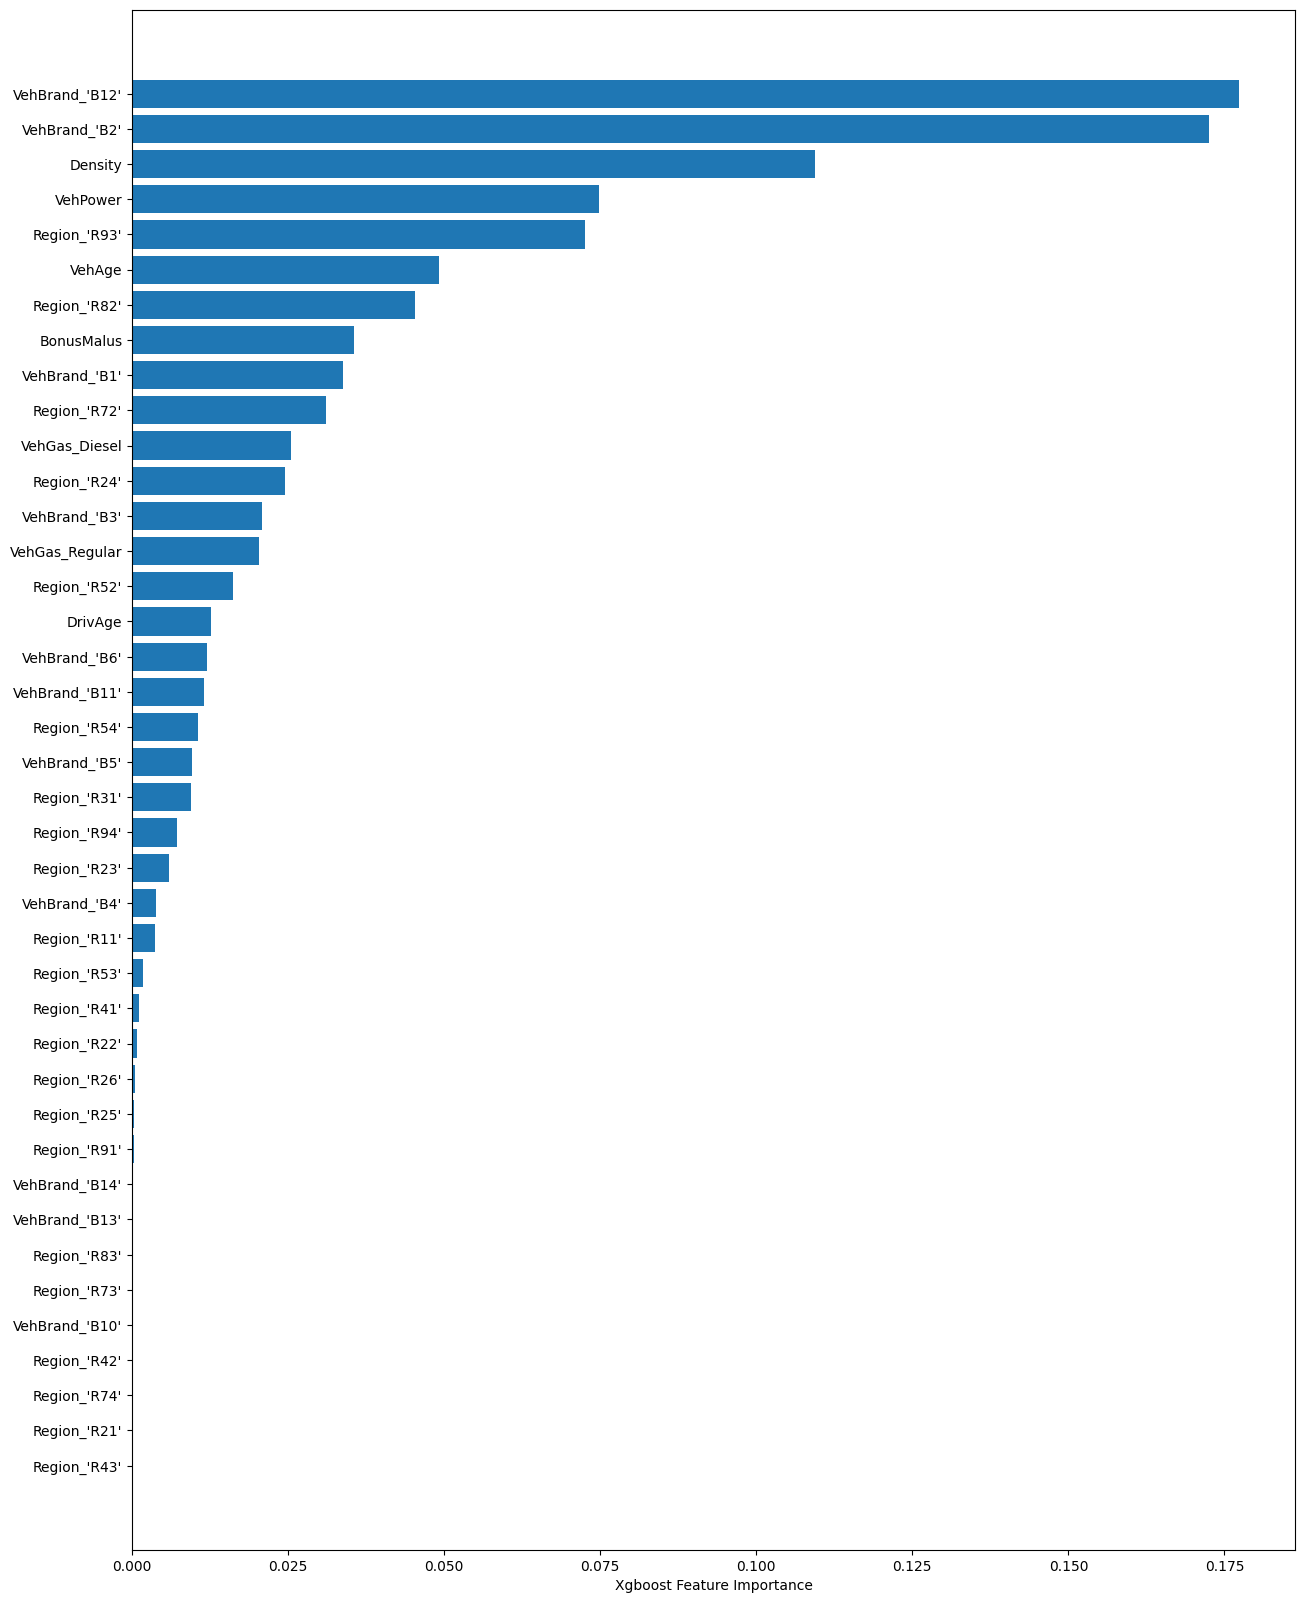

In [26]:
search_eval_plot_xgboost(X_train_log, y_train_log, X_test_log, y_test_log, plot = True)

Appearently the most important feature for XGBoost is some brand type. But we can clearly see that there is **no stark trend towards favourizing categorial or continous features**. 

From what I read the importance of the feature is calculated by "... the number of times the feature is used to split data. This type of feature importance can favourize numerical and high cardinality features" or the gain type. The latter one is actually used here (by default) and calculates the average gain for all splits that use the feature. Nonetheless we can get some insight on what the model's calculations are based on! 

In [27]:
search_eval_plot_xgboost(X_train_sd, y_train_sd, X_test_sd, y_test_sd, plot = False)

Best set of hyperparameters:  {'colsample_bytree': 0.8734665174516678, 'learning_rate': 0.04931384984222167, 'max_depth': 5, 'min_child_weight': 0.8100494300893218, 'n_estimators': 99, 'subsample': 0.9763849082399148}
Best MAE:  -791.6239531802876
MAE of XGBoost on test data is 799.0538811852539
RMSE of XGBoost on test data is 30580.33602821698


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8734665174516678, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04931384984222167, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=0.8100494300893218, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=99,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [28]:
search_eval_plot_xgboost(X_train_mm, y_train_mm, X_test_mm, y_test_mm, plot = False)

Best set of hyperparameters:  {'colsample_bytree': 0.5510842499174076, 'learning_rate': 0.02758310380987055, 'max_depth': None, 'min_child_weight': 0.3699362606027883, 'n_estimators': 64, 'subsample': 0.8777374847111925}
Best MAE:  -719.8198110014142
MAE of XGBoost on test data is 760.6955177017658
RMSE of XGBoost on test data is 30493.99140776571


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5510842499174076, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02758310380987055, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=0.3699362606027883, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=64,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Random Forrest

Also here: Parameters and their ranges to be searched are chosen based on some quick research (again, mostly blogs) and not thoroughly evaluated. In a real case this would be done much more thoroughly. Nonetheless I wanted to implement some sort of parameter search, as picking only single numbers would be even more arbitrary... 

In [29]:

def fit_rf(X_train, y_train): 
    param_dist = {
            "n_estimators": stats.randint(50, 200),
            "max_depth": [None, 3, 5, 10],
            "min_samples_split": np.arange(2, 20, 2), #The minimum number of samples required to split an internal node
            "min_samples_leaf": np.arange(1, 20, 2), #The minimum number of samples required to be at a leaf node
            "max_features": [0.5, 1, "sqrt"], #The number of features to consider when looking for the best split; sqrt = sqrt(n_features)
            "max_samples": [10000] # If bootstrap is True, the number of samples to draw from X to train each base estimator; If int, then draw max_samples samples
            } 
    random_search = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                                param_distributions=param_dist,
                                n_iter=10,
                                cv=5, 
                                scoring='neg_mean_absolute_error')
    random_search.fit(X_train, y_train)
    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best MAE: ", random_search.best_score_)
    return random_search

def search_eval_plot_rf(X_train, y_train, X_test, y_test, plot = True): 
    random_search = fit_rf(X_train,y_train)
    rf = RandomForestRegressor(n_jobs=-1, random_state=42, **random_search.best_params_)
    rf.fit(X_train, y_train)
    if plot: 
        plt.figure(figsize = (15,20))
        importances = pd.Series(rf.feature_importances_, index=X_train.columns)
        importances.nlargest(len(X_train.columns)).plot(kind='barh')

    test_eval_model(X_test, y_test, rf, 'Random Forrest')
    return rf

Best set of hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'max_samples': 10000, 'min_samples_leaf': 13, 'min_samples_split': 8, 'n_estimators': 193}
Best MAE:  -712.866803851051
MAE of Random Forrest on test data is 784.9861082958337
RMSE of Random Forrest on test data is 30397.862754975235


RandomForestRegressor(max_features='sqrt', max_samples=10000,
                      min_samples_leaf=13, min_samples_split=8,
                      n_estimators=193, n_jobs=-1, random_state=42)

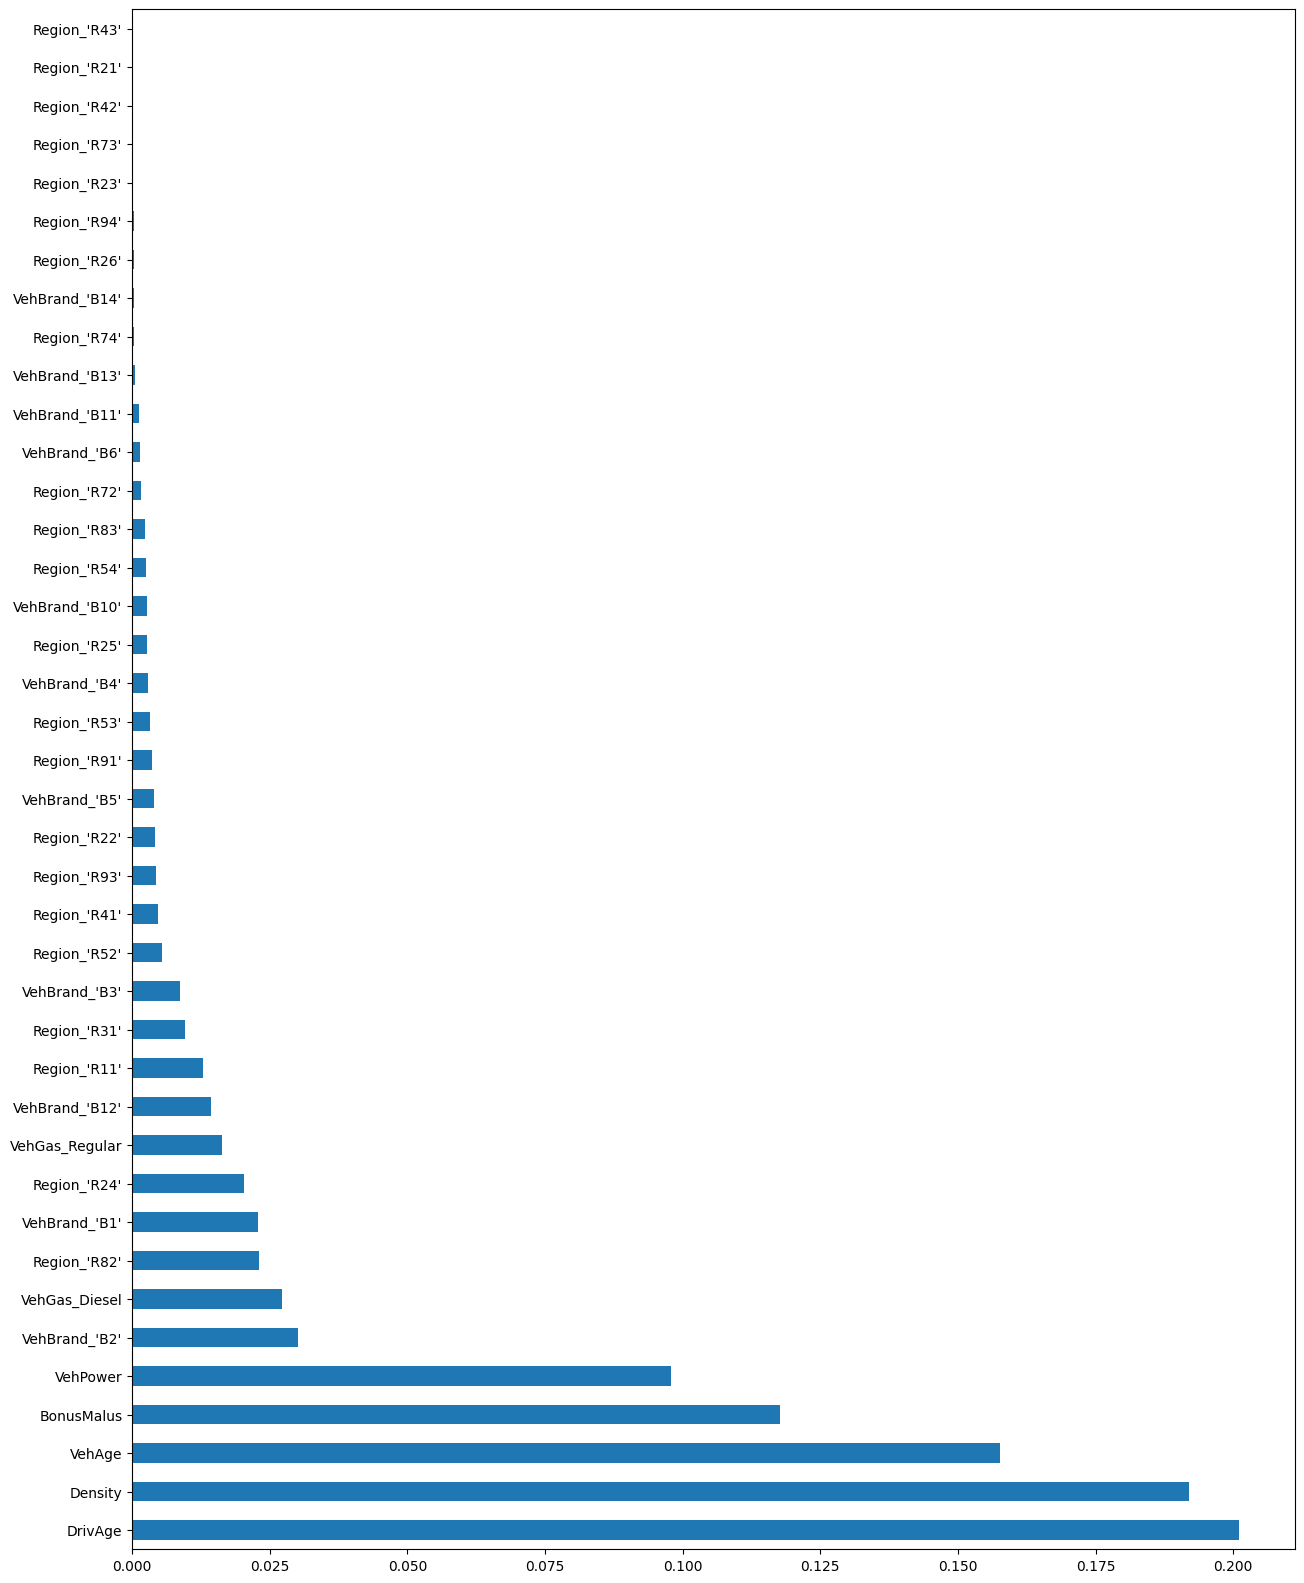

In [30]:
search_eval_plot_rf(X_train_log, y_train_log, X_test_log, y_test_log, plot=True)

Compared to the importance plot above we can clearly see that our Random Forest **favours continous features**, as all of them are among the top five features. Gaining some insight on why this is the case could be very interesting. 

A quick search showed gave not just an insight into how feature importance is calculated for the random forest here, but also why our continous features are favored in the importance plot: "Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. Impurity-based feature importances can be misleading for high cardinality features (many unique values)."

In [31]:
search_eval_plot_rf(X_train_sd, y_train_sd, X_test_sd, y_test_sd, plot=False)

Best set of hyperparameters:  {'max_depth': None, 'max_features': 1, 'max_samples': 10000, 'min_samples_leaf': 19, 'min_samples_split': 6, 'n_estimators': 197}
Best MAE:  -720.3723558031355
MAE of Random Forrest on test data is 786.8062426496195
RMSE of Random Forrest on test data is 30399.910310349627


RandomForestRegressor(max_features=1, max_samples=10000, min_samples_leaf=19,
                      min_samples_split=6, n_estimators=197, n_jobs=-1,
                      random_state=42)

In [32]:
search_eval_plot_rf(X_train_mm, y_train_mm, X_test_mm, y_test_mm, plot=False)

Best set of hyperparameters:  {'max_depth': 3, 'max_features': 1, 'max_samples': 10000, 'min_samples_leaf': 19, 'min_samples_split': 10, 'n_estimators': 68}
Best MAE:  -723.8250548042339
MAE of Random Forrest on test data is 746.0334393174362
RMSE of Random Forrest on test data is 30402.353944631093


RandomForestRegressor(max_depth=3, max_features=1, max_samples=10000,
                      min_samples_leaf=19, min_samples_split=10,
                      n_estimators=68, n_jobs=-1, random_state=42)

#### Results: <br>

**MAE** <br>
Log transform: **XGBoost** (750.5966) < Random Forrest (784.9861) <br>
Standardization: XGBoost (799.0539) < **Random Forrest** (786.8062) <br>
MinMax Random: XGBoost (760.6955) < **Random Forrest** (746.0334)

**RMSE** <br>
Log transform: XGBoost (30663.6785) < **Random Forrest** (30397.8627) <br>
Standardization: XGBoost (30580.3360) < **Random Forrest** (30399.9103) <br>
MinMax Random: XGBoost (30493.9914) < **Random Forrest** (30402.3539)

Conclusion: I'd continue with optimizing Random Forrest rather than my XGBoost model, because it performed slightly better for the metrics above... (Actually this is kind of unexpected, as XGBoost is a later step in the evolution of tree based models)

#### Further ideas how to continue: 
- How can I handle the massive skew in my dependent and independent variables? Maybe I can bin the data and then undersample the most prominent bin (where my target data is 0.0) to balance my data. One problem could be that I loose information... Alternatively we could oversample the underrepresented samples. 
- Understand the data much better. Investigate how the data is generated. Are there any problems with the data generating process? Maybe some bias that I have to consider (or some bug in a software I draw my sample from). How do I handle outliers? Also thoroughly thinking about the data, working with it and talking to other people that know a lot about the domain could yield much better features like the ones above.
- Dig deeper into models for regression tasks! Read papers and blogs on how people model kind of similar problems. This could yield not just insights on modelling insurance data in general but also problems that are often encountered with this kind of data. Also: What are models usually taken into consideration (maybe some generalized linear models or a fancy neural network)? 
- Optimize (hyper)parameters of the chosen model! Often times some improvement can be achieved by finetuning your model rigorously. 